In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np

class GPT2EarlyExitClassifier(torch.nn.Module):
    def __init__(self, model_name, exit_layers, threshold, verbalizers):
        super().__init__()

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.exit_layers = exit_layers            # e.g. [2,4,6,8] or [3,6,9]
        self.threshold = threshold
        self.verbalizers = verbalizers            # {dataset: {class: [words]}}
        self.num_layers = len(self.model.transformer.h)

        # Precompute token IDs for verbalizers
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_lists = []
                for w in words:
                    tok_lists.append(self.tokenizer.encode(" " + w))
                ids[cls] = tok_lists
            self.verbalizer_token_ids[dataset] = ids
            
    @torch.no_grad()
    def classify(self, text, dataset_name):
    
        # USE PROMPT (otherwise GPT-2 is not doing classification)
        prompt = text   # if you want no prompt
        # prompt = self.build_prompt(text, dataset_name)   # if you want prompt
    
        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        outputs = self.model(input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    
        class_verbalizers = self.verbalizer_token_ids[dataset_name]
    
        last_index = input_ids.shape[1] - 1   # <--- IMPORTANT FIX
    
        # EARLY EXIT
        for layer_idx in self.exit_layers:
    
            h = hidden_states[layer_idx][:, last_index, :]   # <--- FIXED
            logits = self.model.lm_head(h)[0]
    
            class_scores = []
            for cls, tok_lists in class_verbalizers.items():
                vals = []
                for tok_list in tok_lists:
                    idx = torch.tensor(tok_list, dtype=torch.long)
                    vals.append(logits[idx].mean().item())
                class_scores.append(float(np.mean(vals)))
    
            class_scores = torch.tensor(class_scores)
            class_probs = torch.softmax(class_scores, dim=-1)
    
            pred = int(torch.argmax(class_probs))
            conf = float(class_probs[pred])
    
            if conf >= self.threshold:
                return pred, layer_idx, conf
    
        # FINAL EXIT
        final_layer = self.num_layers
        h = hidden_states[final_layer][:, last_index, :]    # <--- FIXED
    
        logits = self.model.lm_head(h)[0]
    
        class_scores = []
        for cls, tok_lists in class_verbalizers.items():
            vals = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long)
                vals.append(logits[idx].mean().item())
            class_scores.append(float(np.mean(vals)))
    
        class_scores = torch.tensor(class_scores)
        class_probs = torch.softmax(class_scores, dim=-1)
    
        pred = int(torch.argmax(class_probs))
        conf = float(class_probs[pred])
    
        return pred, final_layer, conf


In [4]:
# ---------------------------------------
# BASELINE classifier (FINAL LAYER ONLY)
# ---------------------------------------
class GPT2BaselineClassifier(torch.nn.Module):
    def __init__(self, model_name, verbalizers):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.verbalizers = verbalizers
        self.num_layers = len(self.model.transformer.h)

        # Precompute tokens
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_list = self.tokenizer.encode(" " + words[0])
                ids[cls] = tok_list
            self.verbalizer_token_ids[dataset] = ids

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]

        outputs = self.model(input_ids, output_hidden_states=True)
        hidden = outputs.hidden_states[self.num_layers][:, -1, :]

        logits = self.model.lm_head(hidden)[0]

        class_verbalizers = self.verbalizer_token_ids[dataset_name]
        scores = []

        for cls, tok_list in class_verbalizers.items():
            idx = torch.tensor(tok_list, dtype=torch.long)
            scores.append(logits[idx].mean().item())

        scores = torch.tensor(scores)
        probs = torch.softmax(scores, dim=-1)

        pred = int(torch.argmax(probs))
        return pred, self.num_layers, float(probs[pred])

In [5]:
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"]
    },
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech"]
    }
}

model = GPT2EarlyExitClassifier(
    model_name="gpt2",
    exit_layers=[2,4,6,8,10,12],
    threshold=0.8,
    verbalizers=verbalizers
)

pred, layer_used, conf = model.classify("This movie was great!", dataset_name="sst2")
print(pred, layer_used, conf)

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


1 2 0.9547190070152283


In [21]:
import time
import numpy as np

from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.amazon import load_amazon
from evaluation.dataset_loaders.imdb import load_imdb
from evaluation.dataset_loaders.dbpedia import load_dbpedia
from evaluation.dataset_loaders.yanswers import load_yahoo


# ---------------------------------------
# Verbalyzers for GPT-2 classification
# ---------------------------------------
verbalizers = {
    "sst2": {
        0: ["negative", "bad", "terrible"],
        1: ["positive", "good", "great"],
    },
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech", "computer"],
    },

    # NEW: IMDB binary sentiment
    "imdb": {
        0: ["negative", "bad", "terrible"],
        1: ["positive", "good", "excellent"],
    },

    # NEW: Amazon Polarity binary sentiment
    "amazon_polarity": {
        0: ["negative", "bad", "poor"],
        1: ["positive", "good", "amazing"],
    }
}

'''verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"],
    },
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech", "computer"],
    },
    "dbpedia": {
    0: ["company", "corporation", "business"],
    1: ["school", "university", "college"],
    2: ["artist", "painter", "musician"],
    3: ["athlete", "player", "sportsman"],
    4: ["leader", "politician", "official"],
    5: ["vehicle", "transport", "machine"],
    6: ["building", "structure", "facility"],
    7: ["nature", "landform", "environment"],
    8: ["village", "town", "settlement"],
    9: ["animal", "creature", "mammal"],
    10: ["plant", "tree", "flora"],
    11: ["album", "music", "record"],
    12: ["film", "movie", "cinema"],
    13: ["book", "novel", "writing"],
    },
    "yahoo": {
    0: ["society", "culture", "people"],
    1: ["science", "math", "physics"],
    2: ["health", "medicine", "medical"],
    3: ["education", "reference", "learning"],
    4: ["computer", "internet", "technology"],
    5: ["sports", "sport", "athletics"],
    6: ["business", "finance", "money"],
    7: ["entertainment", "music", "movies"],
    8: ["family", "relationships", "love"],
    9: ["politics", "government", "law"],
    }
}

# ---------------------------------------
# Load datasets once
# ---------------------------------------
dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("dbpedia", load_dbpedia, "classification"),
    ("yahoo", load_yahoo, "classification")
]'''

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=100),
        "task": task
    }

print("\nAll datasets loaded.\n")


# ---------------------------------------
# Extract (text, label) from any format
# ---------------------------------------
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)


# ---------------------------------------
# Evaluation
# ---------------------------------------
def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        pred, layer, conf = model.classify(text, dataset_name)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "num_samples": total
    }


# ---------------------------------------
# Run baseline + early exit
# ---------------------------------------
results_table = []

# -------------------------
# BASELINE FIRST
# -------------------------
print("\n==============================")
print("Running BASELINE")
print("==============================")

baseline_model = GPT2BaselineClassifier(
    model_name="gpt2",
    verbalizers=verbalizers
)

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })


# -------------------------
# EARLY EXIT NEXT
# -------------------------
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
exit_layers = [6]

for th in thresholds:
    print(f"\n==============================")
    print(f"Running threshold {th}")
    print("==============================")

    model = GPT2EarlyExitClassifier(
        model_name="gpt2",
        exit_layers=exit_layers,
        threshold=th,
        verbalizers=verbalizers
    )

    for name, meta in cached_datasets.items():
        dataset = meta["data"]

        print(f"\nTesting {name} (early_exit threshold={th})...")

        result = evaluate_dataset(model, dataset, name)
        print(name, result)

        results_table.append({
            "dataset": name,
            "threshold": th,
            "mode": "early_exit",
            "metric": result["metric"],
            "score": float(result["score"]),
            "avg_latency_sec": float(result["avg_latency_sec"]),
            "tokens_per_sec": float(result["tokens_per_sec"]),
            "avg_layers_used": float(result["avg_layers_used"]),
            "num_samples": int(result["num_samples"]),
        })

Loading datasets once...

Loading sst2...
Loading agnews...
Loading dbpedia...
Loading yahoo...

All datasets loaded.


Running BASELINE

Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.46, 'avg_latency_sec': 0.022730998992919922, 'tokens_per_sec': 1038.6697041935493, 'avg_layers_used': 12.0, 'num_samples': 100}

Testing BASELINE on agnews...
agnews {'metric': 'accuracy', 'score': 0.57, 'avg_latency_sec': 0.03236906051635742, 'tokens_per_sec': 1578.0501251862768, 'avg_layers_used': 12.0, 'num_samples': 100}

Testing BASELINE on dbpedia...
dbpedia {'metric': 'accuracy', 'score': 0.45, 'avg_latency_sec': 0.03431938886642456, 'tokens_per_sec': 1979.6389808813656, 'avg_layers_used': 12.0, 'num_samples': 100}

Testing BASELINE on yahoo...
yahoo {'metric': 'accuracy', 'score': 0.37, 'avg_latency_sec': 0.026481449604034424, 'tokens_per_sec': 1539.945909675096, 'avg_layers_used': 12.0, 'num_samples': 100}

Running threshold 0.5

Testing sst2 (early_exit threshold=0.5)...
sst

In [22]:
import pandas as pd
df=pd.DataFrame(results_table)
df

,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples
0,sst2,NaN,baseline,accuracy,0.46,0.022731,1038.669704,12.00,100
1,agnews,NaN,baseline,accuracy,0.57,0.032369,1578.050125,12.00,100
2,dbpedia,NaN,baseline,accuracy,0.45,0.034319,1979.638981,12.00,100
3,yahoo,NaN,baseline,accuracy,0.37,0.026481,1539.945910,12.00,100
4,sst2,0.5,early_exit,accuracy,0.62,0.020882,1130.612831,6.00,100
5,agnews,0.5,early_exit,accuracy,0.32,0.031128,1640.943143,6.12,100
6,dbpedia,0.5,early_exit,accuracy,0.30,0.034592,1964.064108,7.86,100
7,yahoo,0.5,early_exit,accuracy,0.28,0.028541,1428.801171,7.92,100
8,sst2,0.6,early_exit,accuracy,0.66,0.021898,1078.179587,6.42,100
9,agnews,0.6,early_exit,accuracy,0.32,0.031176,1638.457261,6.36,100


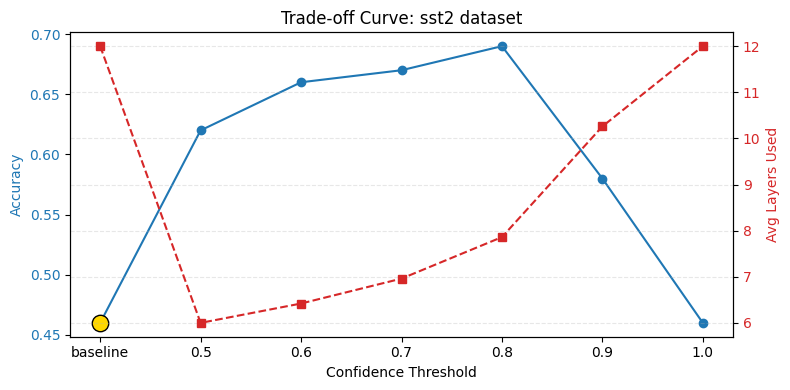

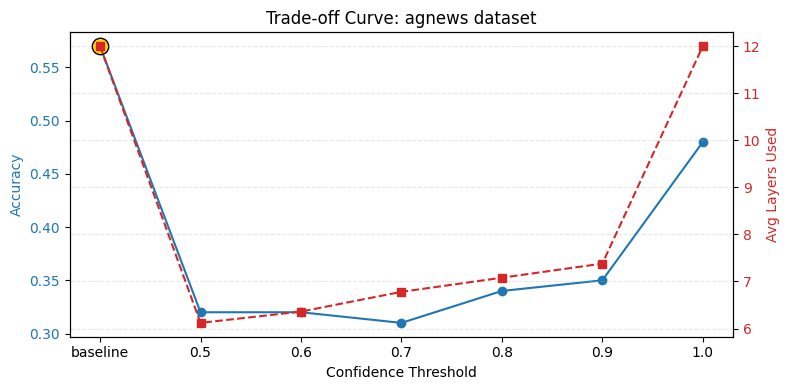

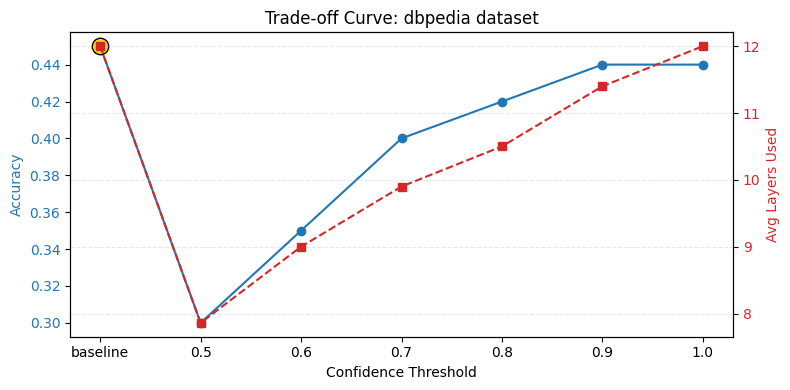

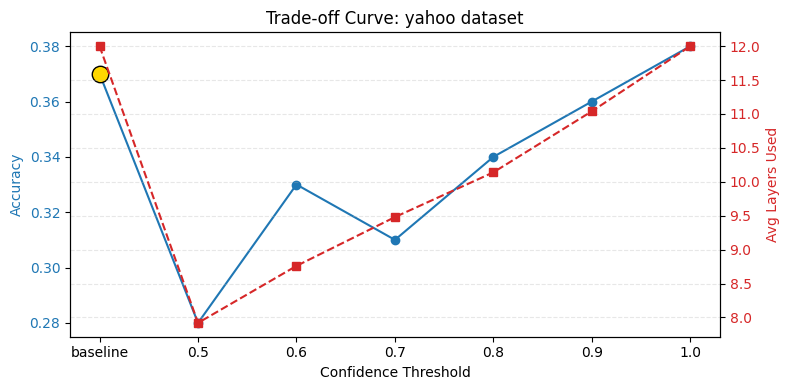

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math

grouped = {}

# Build structured dataset including baseline
for row in results_table:
    ds = row["dataset"]
    if ds not in grouped:
        grouped[ds] = {
            "thresholds": [],
            "scores": [],
            "avg_layers": [],
            "mode": [],
        }

    th = row["threshold"]

    # Replace baseline's NaN with the string "baseline"
    if th is None or (isinstance(th, float) and math.isnan(th)):
        th = "baseline"

    grouped[ds]["thresholds"].append(th)
    grouped[ds]["scores"].append(row["score"])
    grouped[ds]["avg_layers"].append(row["avg_layers_used"])
    grouped[ds]["mode"].append(row["mode"])


# Plot for each dataset
for ds, data in grouped.items():

    thresholds = data["thresholds"]
    scores     = data["scores"]
    layers     = data["avg_layers"]
    modes      = data["mode"]

    # ---- Sort so "baseline" appears first ----
    # baseline = string, others = floats → custom sort key
    def sort_key(x):
        return -1 if x == "baseline" else float(x)

    sorted_idx = sorted(range(len(thresholds)), key=lambda i: sort_key(thresholds[i]))

    thresholds = [thresholds[i] for i in sorted_idx]
    scores     = [scores[i] for i in sorted_idx]
    layers     = [layers[i] for i in sorted_idx]
    modes      = [modes[i] for i in sorted_idx]

    # ---- Categorical x-axis ----
    x_labels = thresholds
    x_pos    = np.arange(len(x_labels))

    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Accuracy curve
    ax1.set_xlabel("Confidence Threshold")
    ax1.set_ylabel("Accuracy", color="tab:blue")
    ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Highlight baseline point
    for i, m in enumerate(modes):
        if m == "baseline":
            ax1.scatter(x_pos[i], scores[i], color="gold", s=140,
                        edgecolor="black", zorder=5, label="Baseline")

    # Layers curve (right axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Avg Layers Used", color="tab:red")
    ax2.plot(x_pos, layers, marker="s", linestyle="--",
             color="tab:red", label="Layers Used")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Put the baseline / threshold labels on x-axis
    plt.xticks(x_pos, x_labels)

    plt.title(f"Trade-off Curve: {ds} dataset")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

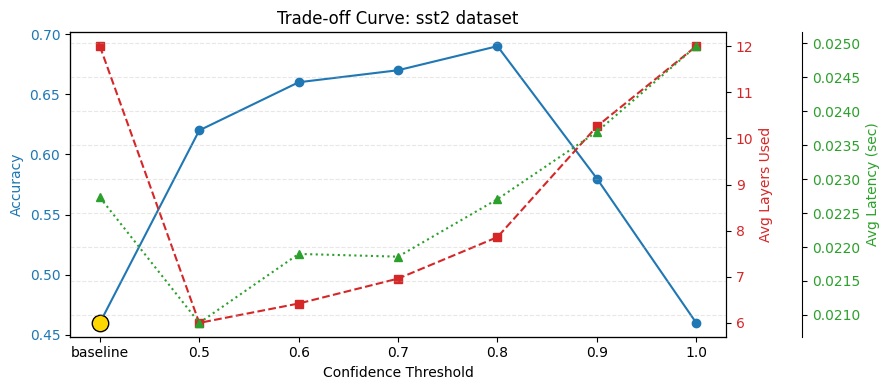

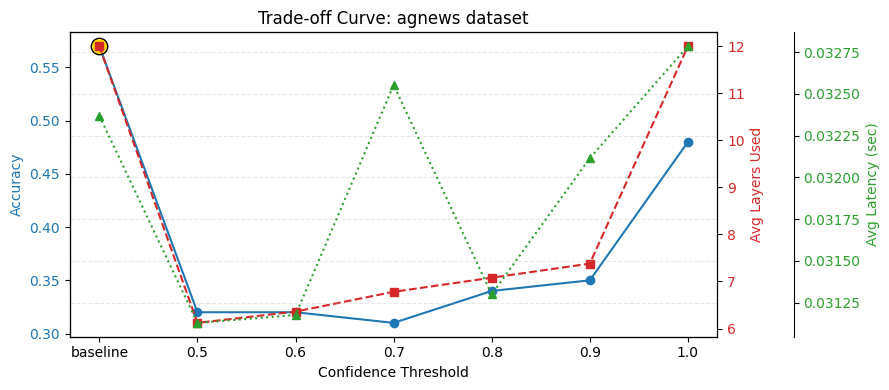

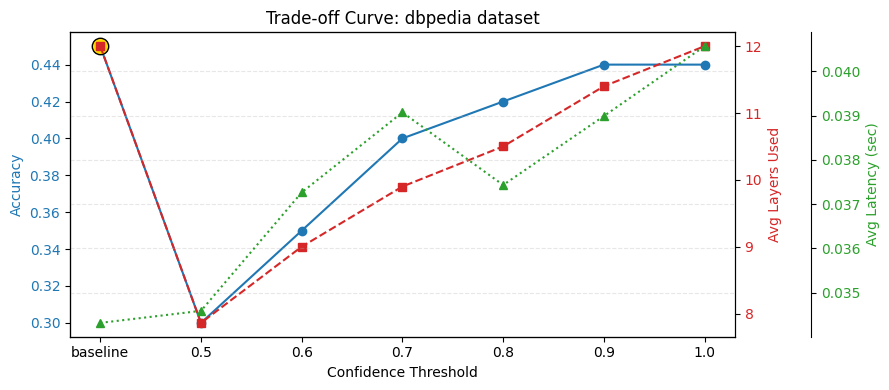

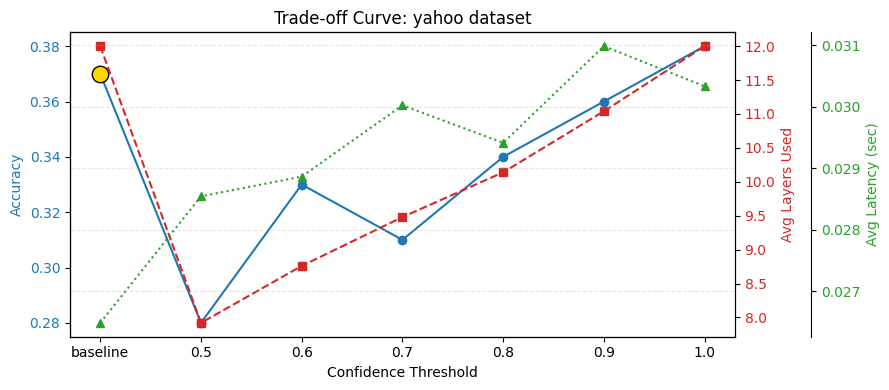

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math

grouped = {}

# Build structured dataset including baseline
for row in results_table:
    ds = row["dataset"]
    if ds not in grouped:
        grouped[ds] = {
            "thresholds": [],
            "scores": [],
            "avg_layers": [],
            "avg_latency": [],   # <<< NEW
            "mode": [],
        }

    th = row["threshold"]

    # Replace baseline's NaN with the string "baseline"
    if th is None or (isinstance(th, float) and math.isnan(th)):
        th = "baseline"

    grouped[ds]["thresholds"].append(th)
    grouped[ds]["scores"].append(row["score"])
    grouped[ds]["avg_layers"].append(row["avg_layers_used"])
    grouped[ds]["avg_latency"].append(row["avg_latency_sec"])   # <<< NEW
    grouped[ds]["mode"].append(row["mode"])


# Plot for each dataset
for ds, data in grouped.items():

    thresholds = data["thresholds"]
    scores     = data["scores"]
    layers     = data["avg_layers"]
    latency    = data["avg_latency"]     # <<< NEW
    modes      = data["mode"]

    # ---- Sort so "baseline" appears first ----
    def sort_key(x):
        return -1 if x == "baseline" else float(x)

    sorted_idx = sorted(range(len(thresholds)), key=lambda i: sort_key(thresholds[i]))

    thresholds = [thresholds[i] for i in sorted_idx]
    scores     = [scores[i]     for i in sorted_idx]
    layers     = [layers[i]     for i in sorted_idx]
    latency    = [latency[i]    for i in sorted_idx]   # <<< NEW
    modes      = [modes[i]      for i in sorted_idx]

    # ---- Categorical x-axis ----
    x_labels = thresholds
    x_pos    = np.arange(len(x_labels))

    fig, ax1 = plt.subplots(figsize=(9, 4))

    # ---- Accuracy curve (left axis) ----
    ax1.set_xlabel("Confidence Threshold")
    ax1.set_ylabel("Accuracy", color="tab:blue")
    ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Highlight baseline point
    for i, m in enumerate(modes):
        if m == "baseline":
            ax1.scatter(
                x_pos[i], scores[i],
                color="gold", s=140, edgecolor="black",
                zorder=5, label="Baseline"
            )

    # ---- Avg Layers Used (right axis #1) ----
    ax2 = ax1.twinx()
    ax2.set_ylabel("Avg Layers Used", color="tab:red")
    ax2.plot(x_pos, layers, marker="s", linestyle="--",
             color="tab:red", label="Layers Used")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # ---- Avg Latency (right axis #2, offset) ----
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 55))   # <<< OFFSET 55 px
    ax3.set_ylabel("Avg Latency (sec)", color="tab:green")
    ax3.plot(x_pos, latency, marker="^", linestyle=":",
             color="tab:green", label="Latency (sec)")
    ax3.tick_params(axis="y", labelcolor="tab:green")

    # ---- X-axis labels ----
    plt.xticks(x_pos, x_labels)

    plt.title(f"Trade-off Curve: {ds} dataset")
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()
